In [ ]:
#Binary Classification of fetal ultrasound images using a InceptionNetV3 Architecture and Segmented dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import tensorflow as tf
import pathlib
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
#define path to dataset
train_dir = 'C:\\Users\\saniy\\Documents\\Rishi work\\ResNet\\Seg\\Segmented-Dataset\\Training'

val_dir = 'C:\\Users\\saniy\\Documents\\Rishi work\\ResNet\\Seg\\Segmented-Dataset\\Testing'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 720 files belonging to 2 classes.


In [3]:
validation_dataset = image_dataset_from_directory(val_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 180 files belonging to 2 classes.


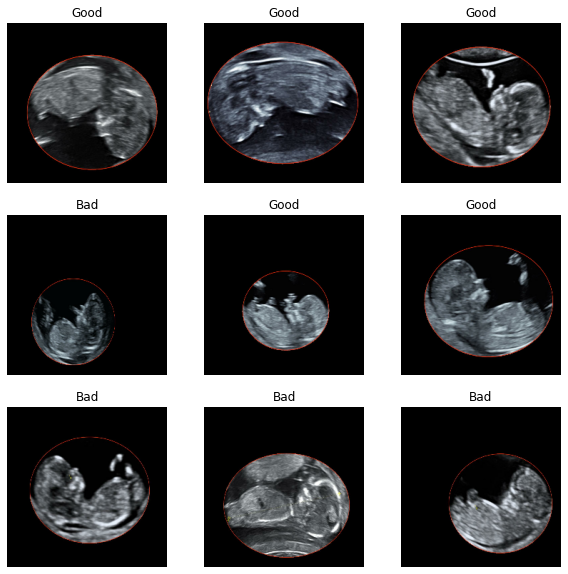

In [4]:
#visualise dataset
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
#autotune improvement in data performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
#data augmentation of images
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

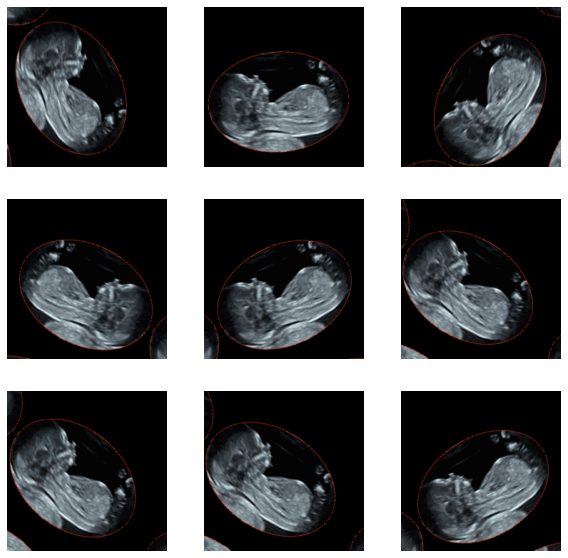

In [7]:
#visualise data augmentation
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [8]:
#image preprocessing using inceptionnet api
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [9]:
#creating base model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [11]:
#set base model trainable to false
base_model.trainable = False

In [12]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [14]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [15]:
#compile layers of the model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
#compile the model
base_learning_rate = 0.0002
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [18]:
#inital model evaluation
initial_epochs = 50

loss0, accuracy0 = model.evaluate(validation_dataset)

6/6 [==============================] - 9s 985ms/step - loss: 0.7255 - accuracy: 0.4475


In [19]:
#record time taken for model to fit
start =time.time()
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
stop =time.time()

Epoch 1/50
23/23 [==============================] - 47s 2s/step - loss: 0.6714 - accuracy: 0.5819 - val_loss: 0.6267 - val_accuracy: 0.5611
Epoch 2/50
23/23 [==============================] - 43s 2s/step - loss: 0.6235 - accuracy: 0.6153 - val_loss: 0.5950 - val_accuracy: 0.5500
Epoch 3/50
23/23 [==============================] - 47s 2s/step - loss: 0.5897 - accuracy: 0.6472 - val_loss: 0.5540 - val_accuracy: 0.6500
Epoch 4/50
23/23 [==============================] - 44s 2s/step - loss: 0.5669 - accuracy: 0.6681 - val_loss: 0.5399 - val_accuracy: 0.6556
Epoch 5/50
23/23 [==============================] - 42s 2s/step - loss: 0.5601 - accuracy: 0.6917 - val_loss: 0.5225 - val_accuracy: 0.6611
Epoch 6/50
23/23 [==============================] - 42s 2s/step - loss: 0.5276 - accuracy: 0.7097 - val_loss: 0.5002 - val_accuracy: 0.7167
Epoch 7/50
23/23 [==============================] - 42s 2s/step - loss: 0.5231 - accuracy: 0.7028 - val_loss: 0.4848 - val_accuracy: 0.7444
Epoch 8/50
23/23 [==

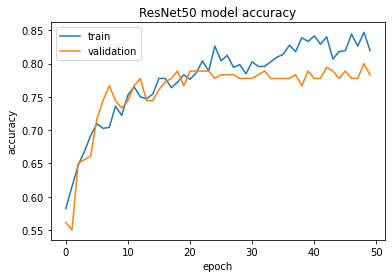

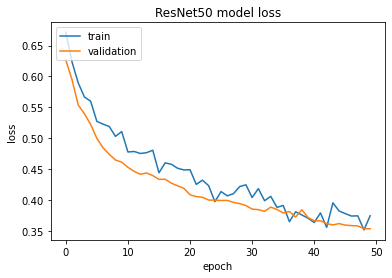

In [21]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Model-accuracy-Inception13.svg')
plt.show()
    
    # "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Model-loss-Inception13.svg')
plt.show()


In [22]:
timeTaken = stop - start
print(timeTaken)

2150.4343090057373


In [24]:
#save model
model.save("inceptionNetV3.h5")